# Setup

In [1]:
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, accuracy_score
from collections import defaultdict
import plotly.graph_objects as go
from sae_lens import SAE, HookedSAETransformer
from functools import partial
from transformers import AutoTokenizer, AutoModel
import pickle
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
!pip install sae_lens

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 15.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.1/920.1 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.2/189.2 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4

In [ ]:
!pip install nltk

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

In [ ]:
from datasets import load_dataset

ds = load_dataset("google-research-datasets/go_emotions", "simplified")

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [ ]:
from sae_lens import (
    SAE,
    ActivationsStore,
    HookedSAETransformer,
    LanguageModelSAERunnerConfig,
    SAEConfig,
    SAETrainingRunner,
    upload_saes_to_huggingface,
)

In [ ]:
from datasets import concatenate_datasets

ds = concatenate_datasets([ds['train'], ds['validation'], ds['test']])
ds

Dataset({
    features: ['text', 'labels', 'id'],
    num_rows: 54263
})

In [ ]:
label_names = ds.features["labels"].feature.names


In [ ]:
targeted_emotions = ['joy', 'anger', 'disgust', 'sadness', 'love', 'fear', 'excitement']
labels = []
for em in targeted_emotions:
  labels.append(label_names.index(em))

In [ ]:
ds = ds.filter(lambda x: any(label in labels for label in x['labels']))

Filter:   0%|          | 0/54263 [00:00<?, ? examples/s]

In [ ]:
ds = ds.filter(lambda x: len(x['labels']) == 1)

Filter:   0%|          | 0/10347 [00:00<?, ? examples/s]

In [ ]:
import numpy as np

ids = np.load("ds_filt.npy")

In [ ]:
filtered_ds = ds.filter(lambda x: x["id"] in ids)


Filter:   0%|          | 0/54263 [00:00<?, ? examples/s]

In [ ]:
ds = filtered_ds

In [ ]:
len(filtered_ds)

3037

In [ ]:
ds

Dataset({
    features: ['text', 'labels', 'id'],
    num_rows: 3037
})

In [ ]:
texts = [s['text'] for s in ds]
labels = [s['labels'] for s in ds]

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


In [ ]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

<ipython-input-46-467e4a0e4f35>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=word_freq_df.head(30), x='word', y='count', palette='viridis')


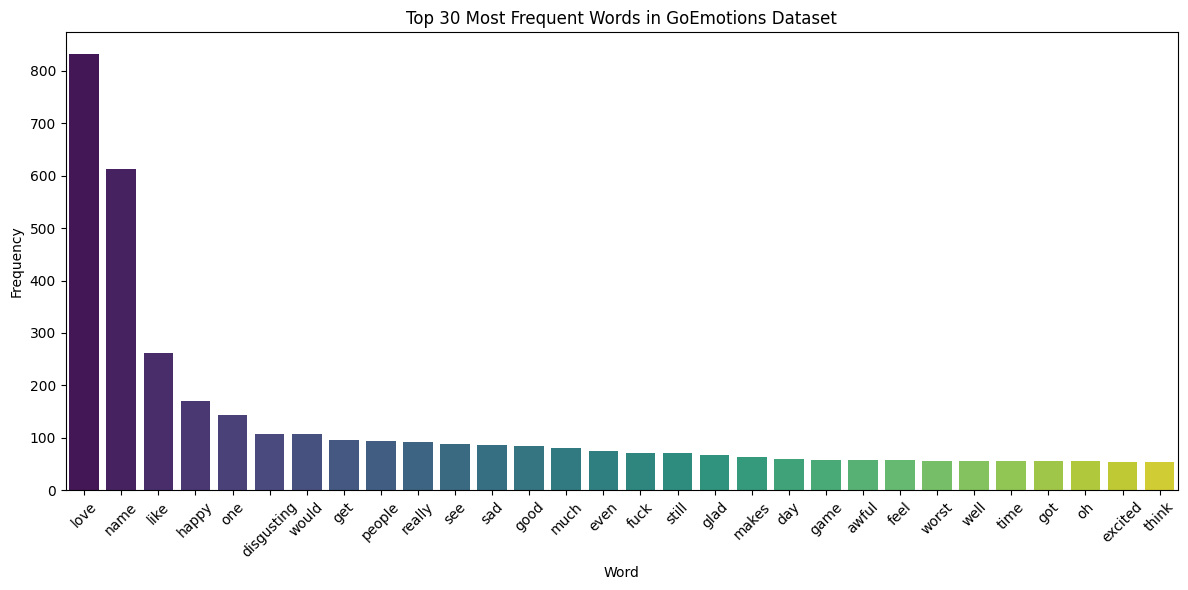

In [ ]:
word_counter = Counter()
for sentence in texts:
    words = re.findall(r'\b\w+\b', sentence.lower())
    filt_words = [w for w in words if(w not in stop_words) and (len(w)>1)]
    word_counter.update(filt_words)

word_freq_df = pd.DataFrame(word_counter.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=word_freq_df.head(30), x='word', y='count', palette='viridis')
plt.xticks(rotation=45)
plt.title('Top 30 Most Frequent Words in GoEmotions Dataset')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
word_counter

Counter({'make': 44,
         'feel': 57,
         'threatened': 1,
         'stupidly': 1,
         'stubborn': 1,
         'stubbornly': 1,
         'stupid': 7,
         'happy': 171,
         'able': 8,
         'help': 22,
         'oh': 55,
         'forgive': 2,
         'us': 29,
         'trying': 20,
         'exciting': 9,
         'atmosphere': 1,
         'homecourt': 1,
         'love': 832,
         'rocket': 1,
         'blasted': 1,
         'wonder': 3,
         'songs': 7,
         'written': 3,
         'reference': 7,
         'tracks': 2,
         'except': 3,
         'acura': 1,
         'intergul': 1,
         'kill': 12,
         'scum': 4,
         'youre': 3,
         'disgusting': 108,
         'piece': 4,
         'filth': 1,
         'yeah': 46,
         'let': 28,
         'wrap': 1,
         'as4': 1,
         'suddenly': 3,
         'much': 81,
         'excited': 54,
         's11': 1,
         'adore': 5,
         'comment': 16,
         'section': 2

In [ ]:
new = [w for w, c in word_counter.items() if c > 5]

In [ ]:
len(new)

516

## Classification with Gemma

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_id = "google/gemma-2b"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto", torch_dtype=torch.float16)
model.eval()


tokenizer_config.json:   0%|          | 0.00/33.6k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
      )
    )
    (norm): GemmaRMSNorm((2048,), 

In [ ]:
def build_prompt(shots=('joy', 'sadness'), prompt_index=1):
    sample_pool = {
        'joy': 'My first child was born.',
        'anger': 'My husband missed an important call, because his phone was on silent AGAIN!',
        'disgust': 'I saw mouldy food.',
        'sadness': 'My dog died last week.',
        'love': 'I told my partner I loved them.',
        'fear': 'I was confronted by a thief.',
        'excitement': 'I got an A in my exam!'
    }

    # Filter and prepare few-shot examples from the selected emotions
    selected_shots = [(sample_pool[e], e) for e in shots if e in sample_pool]

    emotion_list = "Consider this list of emotions: joy, anger, disgust, sadness, love, fear, excitement. "

    templates = [
        "What are the inferred emotions in the following contexts?",
        emotion_list + "What are the inferred emotions in the following contexts?",
        "",
        "Guess the emotion.",
        "Decipher the emotion from the following statements: ",
        "Decipher the label for the following statements: ",
        "What is the label, for the statement? ",
        "What is the label, given the context? ",
        emotion_list + "Decipher the emotion from the following statements: ",
        emotion_list + "Decipher the label for the following statements: ",
    ]

    header = templates[prompt_index]
    body = header.strip()

    for text, emotion in selected_shots:
        body += f" Context: {text} Answer: {emotion}"

    return lambda x: f"{body} Context: {x} Answer:"



In [ ]:
from tqdm import tqdm

def classify_with_gemma(ds, tokenizer, model, targeted_emotions, prompt_index=1, shot_emotions=None):
    if shot_emotions is None:
        shot_emotions = targeted_emotions[:7]

    prompt_func = build_prompt(shots=shot_emotions, prompt_index=prompt_index)
    preds = []

    for example in tqdm(ds, desc="Classifying with Gemma (few-shot)"):
        text = example['text']
        prompt = prompt_func(text)

        inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(model.device)
        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=3, do_sample=False, pad_token_id=tokenizer.eos_token_id)

        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
        #print(decoded)
        pred = decoded[len(prompt):].strip().split()[0].lower()

        if pred in targeted_emotions:
            preds.append(targeted_emotions.index(pred))
        else:
            preds.append("other")


    return preds



In [ ]:
preds_model = classify_with_gemma(ds, tokenizer, model, targeted_emotions, prompt_index=1)

Classifying with Gemma (few-shot): 100%|██████████| 6887/6887 [12:58<00:00,  8.85it/s]


In [ ]:
preds_filtered = []
for pred in preds_model:
    if isinstance(pred, int):
        emotion = targeted_emotions[pred]
        if emotion in label_names:
            preds_filtered.append(label_names.index(emotion))  # map to ds label ID
        else:
            preds_filtered.append("-1")  # or -1, or skip it
    else:
        preds_filtered.append("-1")

In [ ]:
texts = [item['text'] for item in ds ]
labels = [item['labels'] for item in ds ]

In [ ]:
labels_flat = [lbl[0] for lbl in labels]

In [ ]:
labels_flat = [int(x) for x in labels_flat]
preds_filtered = [int(x) for x in preds_filtered]


In [ ]:
ds_1 = ds.add_column("pred", preds_filtered)
ds_1 = ds_1.add_column('true', labels_flat)
ds_filtered = ds_1.filter(lambda x: x["true"] == x["pred"])


Flattening the indices:   0%|          | 0/6887 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6887 [00:00<?, ? examples/s]

In [ ]:
ds_filtered

Dataset({
    features: ['text', 'labels', 'id', 'pred', 'true'],
    num_rows: 3037
})

In [ ]:
ids = [item['id'] for item in ds_filtered]

In [ ]:
import numpy as np
from google.colab import files

np.save("ds_filt.npy", ids)
files.download("ds_filt.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Visualizations

In [ ]:
true = [label_names[l] for l in labels_flat]
pred = [label_names[l] for l in preds_filtered]

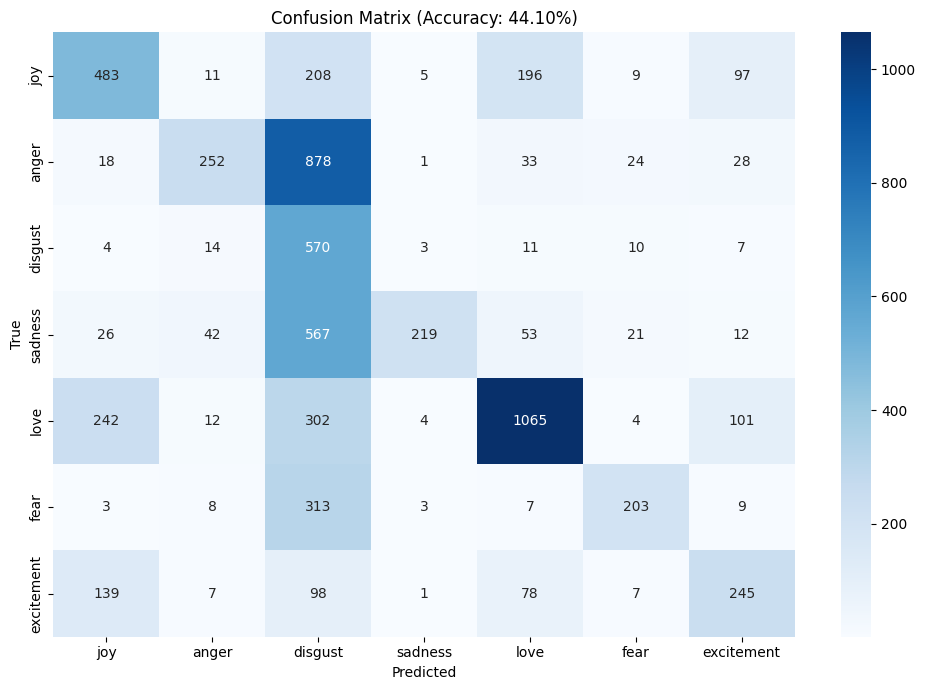

In [ ]:
conf_mat = confusion_matrix(true, pred, labels=targeted_emotions)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True,
            xticklabels=targeted_emotions,
            yticklabels=targeted_emotions,
            fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix (Accuracy: {accuracy:.2%})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [ ]:
def plot_sankey(true_indices, pred_indices, targ_em, label_names):

    true_labels = [label_names[i] for i in true_indices]
    pred_labels = [label_names[i] for i in pred_indices]

    all_emotions = sorted(set(true_labels + pred_labels))

    label_list = all_emotions + [f"pred_{l}" for l in all_emotions]
    label_idx = {l: i for i, l in enumerate(label_list)}

    emotion_to_color = {
        'joy': "#FF0000",
        'anger': "#FFA500",
        'sadness': "#FFFF00",
        'fear': "#27ae60",
        'disgust': "#7f8c8d",
        'love': "#e91e63",
        'excitement': "#f39c12",
        'neutral': "#bdc3c7"
    }

    node_colors = [emotion_to_color.get(e, "#CCCCCC") for e in all_emotions]
    node_colors += node_colors


    counter = defaultdict(int)
    for t, p in zip(true_labels, pred_labels):
        src = label_idx[t]
        tgt = label_idx[f"pred_{p}"]
        counter[(src, tgt)] += 1

    link_source, link_target, link_value, link_color = [], [], [], []

    all_values = list(counter.values())
    max_val = max(all_values)

    for (src, tgt), val in counter.items():
        link_source.append(src)
        link_target.append(tgt)
        link_value.append(val)

        norm_alpha = min(1.0, max(0.2, val / max_val))

        hex_color = node_colors[src].lstrip('#')
        r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
        link_color.append(f'rgba({r},{g},{b},{norm_alpha:.2f})')


    fig = go.Figure(go.Sankey(
        arrangement="snap",
        node=dict(
            pad=15,
            thickness=25,
            line=dict(color="black", width=0.5),
            label=label_list,
            color=node_colors
        ),
        link=dict(
            source=link_source,
            target=link_target,
            value=link_value,
            color=link_color,
        )
    ))

    fig.update_layout(
        title_text="Emotion Classification Flow (True → Predicted)",
        font_size=13,
        margin=dict(l=40, r=40, t=50, b=40),
        width=600,
        height=600
    )

    fig.show()





In [ ]:
plot_sankey(labels_flat, preds_filtered, targeted_emotions, label_names)

# Collecting activations for targeted neurons

In [ ]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [ ]:
from sae_lens import SAE, ActivationsStore, HookedSAETransformer

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
torch.set_grad_enabled(False)

gemma_sae, cfg_dict, sparsity = SAE.from_pretrained(
    release="gemma-scope-2b-pt-res",
    sae_id="layer_20/width_16k/average_l0_71",
    device=str(device),
)

gemma = HookedSAETransformer.from_pretrained("google/gemma-2-2b", device=device)

params.npz:   0%|          | 0.00/302M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/818 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/481M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

Loaded pretrained model google/gemma-2-2b into HookedTransformer


In [ ]:
texts = [item['text'] for item in ds ]
labels = [item['labels'] for item in ds ]

In [ ]:
with open("emotional_n_02_thresh.pkl", "rb") as f:
    neurons = pickle.load(f)

In [ ]:
batch_size = 4
max_length = 400
results = []

for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
    try:
        gc.collect()
        torch.cuda.empty_cache()

        # Get batch
        batch_texts = texts[i:i + batch_size]

        # Tokenize
        tokenized = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length
        )
        input_ids = tokenized["input_ids"].to(device)

        # Forward pass with SAE and cache activations
        _, cache = gemma.run_with_cache_with_saes(
            input_ids,
            saes=[gemma_sae],
            stop_at_layer=gemma_sae.cfg.hook_layer + 1,
            names_filter=[f"{gemma_sae.cfg.hook_name}.hook_sae_acts_post"],
        )

        # SAE activations (features)
        sae_acts = cache[f"{gemma_sae.cfg.hook_name}.hook_sae_acts_post"]  # [B, T, F]
        final_acts = sae_acts[:, -1, :].detach().cpu()

        # Sparsity = number of active features
        sparsity = (sae_acts[:, -1, :] > 1).sum(dim=-1)  # [B]

        decoded_tokens = [tokenizer.convert_ids_to_tokens(ids) for ids in input_ids]


        for i in range(len(batch_texts)):
            results.append({
                "input_ids": input_ids[i].detach().cpu(),              # torch.Tensor
                "tokens": decoded_tokens[i],                          # list of strings
                "activation": final_acts[i],                          # torch.Tensor
                "sparsity": int(sparsity[i]),                         # int
            })

        # Cleanup
        del cache, sae_acts, final_acts, sparsity, input_ids, tokenized
        torch.cuda.empty_cache()

    except RuntimeError as e:
        print(f"⚠️ OOM on batch {i}-{i+batch_size}: {e}")
        torch.cuda.empty_cache()

Processing batches: 100%|██████████| 1390/1390 [14:24<00:00,  1.61it/s]


In [ ]:
for r, l in zip(results, labels):
  r['label'] = l

In [ ]:
len(results)

3037

In [ ]:
with open("sae_results.pkl", "wb") as f:
    pickle.dump(results, f)

In [ ]:
targ_neurons = [13324, 14857, 2438, 12881, 4560, 1898, 8366, 7077, 8094, 3232, 6953, 6953, 13324, 4456, 7077, 808, 230, 281, 8783, 4305, 7717, 230, 7688, 15261, 4305, 3636, 4326, 11491, 4305, 5413, 9618, 15539]

In [ ]:
batch_size = 4
max_length = 40
activation_threshold = 1.0
targ_neurons = set(targ_neurons)
results = []

for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):

        gc.collect()
        torch.cuda.empty_cache()

        batch_texts = texts[i:i + batch_size]

        tokenized = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length
        )
        input_ids = tokenized["input_ids"].to(device)

        _, cache = gemma.run_with_cache_with_saes(
            input_ids,
            saes=[gemma_sae],
            stop_at_layer=gemma_sae.cfg.hook_layer + 1,
            names_filter=[f"{gemma_sae.cfg.hook_name}.hook_sae_acts_post"],
        )

        sae_acts = cache[f"{gemma_sae.cfg.hook_name}.hook_sae_acts_post"].detach().cpu()  # [B, T, F]
        final_acts = sae_acts[:, -1, :]  # [B, F]
        decoded_tokens = [tokenizer.convert_ids_to_tokens(ids) for ids in input_ids]

        for j in range(len(batch_texts)):
            token_acts = sae_acts[j]  # [T, F]
            filtered_entries = []

            for t in range(token_acts.shape[0]):  # iterate over token positions
                for f in targ_neurons:
                    act_val = token_acts[t, f].item()
                    if act_val > activation_threshold:
                        filtered_entries.append((t, f, act_val))

            final_filtered = {
                f: final_acts[j, f].item()
                for f in targ_neurons
                if final_acts[j, f].item() > activation_threshold
            }

            results.append({
                "input_ids": input_ids[j].detach().cpu(),
                "tokens": decoded_tokens[j],
                "activation_targeted": final_filtered,
                "active_neurons": filtered_entries,
                "sparsity": len(filtered_entries),
            })

        del cache, sae_acts, final_acts, input_ids, tokenized
        torch.cuda.empty_cache()

Processing batches: 100%|██████████| 1390/1390 [12:36<00:00,  1.84it/s]


In [ ]:
for r, l in zip(results, labels):
  r['label'] = l

In [ ]:
with open("sae_results_tokens_top_k.pkl", "wb") as f:
    pickle.dump(results, f)


# fixed vocab

In [ ]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")

tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [ ]:
from sae_lens import SAE, ActivationsStore, HookedSAETransformer

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
torch.set_grad_enabled(False)

gemma_sae, cfg_dict, sparsity = SAE.from_pretrained(
    release="gemma-scope-2b-pt-res",
    sae_id="layer_20/width_16k/average_l0_71",
    device=str(device),
)

gemma = HookedSAETransformer.from_pretrained("google/gemma-2-2b", device=device)

params.npz:   0%|          | 0.00/302M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/818 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/481M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

Loaded pretrained model google/gemma-2-2b into HookedTransformer


In [ ]:
vocab_set = set()

with open("NRC-Emotion-Lexicon-Wordlevel-v0.92.txt", "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split()
        if parts:
            vocab_set.add(parts[0])

print("Total unique words:", len(vocab_set))
print("Sample:", list(vocab_set)[:10])


Total unique words: 14154
Sample: ['cheerfulness', 'hush', 'pink', 'somatic', 'tense', 'noble', 'request', 'television', 'hammock', 'occlusion']


In [ ]:
# version where at least 1 emotion labeled

filtered_vocab = set()

with open("NRC-Emotion-Lexicon-Wordlevel-v0.92.txt", "r") as f:
    for line in f:
        word, emotion, label = line.strip().split("\t")
        if label == "1":
            filtered_vocab.add(word)

In [ ]:
len(filtered_vocab)

6453

In [ ]:
vocab_set = filtered_vocab


In [ ]:
for word, count in word_counter.items():
  filtered_vocab.add(word)


filtered_vocab = list(filtered_vocab)
vocab_set = filtered_vocab

In [ ]:
len(vocab_set)

10380

In [ ]:
with open("emotional_n_02_thresh.pkl", "rb") as f:
    neurons = pickle.load(f)

In [ ]:
batch_size = 4
max_length = 40
activation_threshold = 0.0
word_to_activations = defaultdict(list)

texts = [s["text"] for s in ds]

word_pattern = re.compile(r'\b({})\b'.format('|'.join(map(re.escape, vocab_set))), flags=re.IGNORECASE)
word_index_map = defaultdict(list)

# Build inverted index: word -> list of sentence indices where it appears
for idx, sentence in tqdm(enumerate(texts), total=len(texts), desc="Indexing sentences"):
    matches = word_pattern.findall(sentence)
    for word in set(matches):
        word_index_map[word.lower()].append(idx)



Indexing sentences: 100%|██████████| 3037/3037 [00:06<00:00, 471.02it/s]


In [ ]:
def collect_word_activations(texts, vocab_set, tokenizer, gemma, gemma_sae, device, target_neurons,
                             batch_size=4, max_length=40, activation_threshold=1.0, top_k=5):

    word_to_activations = defaultdict(list)
    word_to_high_acts = defaultdict(list)
    word_pattern = re.compile(r'\b({})\b'.format('|'.join(map(re.escape, vocab_set))), flags=re.IGNORECASE)

    # Map vocab words to dataset indices
    word_index_map = defaultdict(list)
    for idx, sentence in tqdm(enumerate(texts), total=len(texts), desc="Indexing sentences"):
        matches = word_pattern.findall(sentence)
        for word in set(matches):
            word_index_map[word.lower()].append(idx)

    for word in tqdm(vocab_set, desc="Processing vocab words"):
        word = word.lower()
        indices = word_index_map.get(word, [])[:20]
        if not indices:
            continue

        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_texts = [texts[j] for j in batch_indices]

            gc.collect()
            torch.cuda.empty_cache()

            tokenized = tokenizer(
                batch_texts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=max_length
            )
            input_ids = tokenized["input_ids"].to(device)

            try:
                _, cache = gemma.run_with_cache_with_saes(
                    input_ids,
                    saes=[gemma_sae],
                    stop_at_layer=gemma_sae.cfg.hook_layer + 1,
                    names_filter=[f"{gemma_sae.cfg.hook_name}.hook_sae_acts_post"],
                )
            except Exception as e:
                print(f"Skipping batch due to error: {e}")
                continue

            sae_acts = cache[f"{gemma_sae.cfg.hook_name}.hook_sae_acts_post"].detach().cpu()  # [B, T, F]

            for b in range(sae_acts.shape[0]):
                tokens = tokenizer.convert_ids_to_tokens(input_ids[b])
                token_acts = sae_acts[b]  # [T, F]
                word_pos = [t for t, tok in enumerate(tokens) if word in tok.lower()]
                if not word_pos:
                    continue

                # Mean over all positions where word appears → vector representation
                mean_vector = token_acts[word_pos].mean(dim=0)[target_neurons].numpy()
                word_to_activations[word].append(mean_vector)

                # Collect all high-activation events for interpretability
                for t in word_pos:
                    for f in target_neurons:
                        val = token_acts[t, f].item()
                        if val > activation_threshold:
                            word_to_high_acts[word].append((tokens[t], f, val))

    # Final top-k mean vector per word (filtering out zero vectors)
    def topk_mean(arrs, k=top_k):
        if len(arrs) <= k:
            return np.mean(arrs, axis=0)
        scores = [np.linalg.norm(vec) for vec in arrs]
        topk_indices = np.argsort(scores)[-k:]
        topk_vecs = [arrs[i] for i in topk_indices]
        return np.mean(topk_vecs, axis=0)

    word_to_sae_vec = {
        w: topk_mean(vectors)
        for w, vectors in word_to_activations.items()
        if vectors
    }

    return word_to_sae_vec, word_to_high_acts


In [ ]:
word_to_sae_vec, word_to_high_acts = collect_word_activations(
    texts=texts,
    vocab_set=vocab_set,
    tokenizer=tokenizer,
    gemma=gemma,
    gemma_sae=gemma_sae,
    device=device,
    target_neurons=list(neurons),
    batch_size=4,
    max_length=40,
    activation_threshold=1.0,
    top_k=5
)


Processing vocab words: 100%|██████████| 10380/10380 [50:44<00:00,  3.41it/s]


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def extract_top_words_per_neuron(word_to_sae_vec, target_neurons, top_k=10, diversity=True, min_score_threshold=5.0):
    top_words_per_neuron = {}
    neuron_to_index = {n: i for i, n in enumerate(target_neurons)}
    all_words = list(word_to_sae_vec.keys())
    vectors = np.stack([word_to_sae_vec[w] for w in all_words])  # shape: [#words, #neurons]

    for neuron in target_neurons:
        idx = neuron_to_index[neuron]
        scores = vectors[:, idx]
        sorted_indices = np.argsort(-scores)

        top_words = []
        used_vecs = []

        for i in sorted_indices:
            score = scores[i]
            if score < min_score_threshold:
                break  # stop early if score drops below threshold

            word = all_words[i]
            vec = word_to_sae_vec[word]

            if not diversity or not used_vecs:
                top_words.append((word, score))
                used_vecs.append(vec)
            else:
                sims = cosine_similarity([vec], used_vecs)[0]
                if np.max(sims) < 0.9:
                    top_words.append((word, score))
                    used_vecs.append(vec)

            if len(top_words) >= top_k:
                break

        if top_words:
            print(f"Neuron {neuron} → Collected {len(top_words)} words (min activation = {top_words[-1][1]:.4f})")
            top_words_per_neuron[neuron] = top_words
        else:
            print(f"Neuron {neuron} → No words above threshold ({min_score_threshold})")

    return top_words_per_neuron





In [ ]:
top_words_per_neuron = extract_top_words_per_neuron(word_to_sae_vec, neurons, top_k=30, diversity=True)

Neuron 2438 → Collected 30 words (min activation = 11.7529)
Neuron 15366 → Collected 30 words (min activation = 12.6547)
Neuron 14857 → Collected 30 words (min activation = 10.0539)
Neuron 13324 → Collected 30 words (min activation = 16.5539)
Neuron 16148 → Collected 3 words (min activation = 5.7349)
Neuron 7579 → Collected 30 words (min activation = 15.2526)
Neuron 7077 → Collected 30 words (min activation = 15.1551)
Neuron 6953 → Collected 30 words (min activation = 9.5335)
Neuron 5810 → Collected 30 words (min activation = 8.7504)
Neuron 15539 → Collected 30 words (min activation = 10.3616)
Neuron 3636 → Collected 30 words (min activation = 8.8280)
Neuron 2249 → Collected 25 words (min activation = 5.1630)
Neuron 4560 → Collected 30 words (min activation = 12.7182)
Neuron 7769 → Collected 30 words (min activation = 8.6992)
Neuron 230 → Collected 26 words (min activation = 5.0962)
Neuron 4326 → Collected 30 words (min activation = 13.5435)
Neuron 4456 → Collected 30 words (min activa

In [ ]:
import json

with open("word_to_high_acts_drop_stop_30.json", "w") as f:
    json.dump(word_to_high_acts, f)

with open("word_to_sae_vec_reduced_drop_stop_30.json", "w") as f:
    json.dump({k: v.tolist() for k, v in word_to_sae_vec.items()}, f)


In [ ]:
word_to_sae_vec

{'exciting': array([0.       , 4.267621 , 0.       , 0.       , 0.       , 2.1062462,
        1.5660242, 0.       , 0.       , 0.       , 3.2591195, 0.       ,
        1.4976761, 0.       , 0.       , 1.9452963, 0.       , 0.       ,
        0.       , 0.       ], dtype=float32),
 'tells': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], dtype=float32),
 'pairing': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], dtype=float32),
 'lol': array([ 0.       ,  3.650603 ,  0.       ,  0.       ,  0.       ,
         0.       , 24.80838  ,  1.4665506,  0.       ,  3.0849457,
         4.8404646,  3.9623058,  6.3589516,  0.       ,  1.5152377,
         0.       , 18.44138  ,  0.       , 10.734745 ,  0.       ],
       dtype=float32),
 'chair': array([12.783045 ,  0.       , 40.248623 , 32.532    ,  0.       ,
        18.13796  ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.  

In [ ]:
import json

# Convert activation values to float and structure for JSON
top_words_serializable = {
    int(neuron): [{"word": w, "activation": float(a)} for w, a in word_list]
    for neuron, word_list in top_words_per_neuron.items()
}

# Save to file
with open("top_words_per_neuron_drop_stop_30.json", "w") as f:
    json.dump(top_words_serializable, f, indent=2)


In [ ]:
top_words_per_neuron

{2438: [('dumbass', np.float32(38.987297)),
  ('fallacy', np.float32(38.0002)),
  ('slavery', np.float32(26.290684)),
  ('said', np.float32(20.67485)),
  ('daft', np.float32(20.44965)),
  ('coin', np.float32(19.842182)),
  ('marriage', np.float32(19.654266)),
  ('chill', np.float32(17.46932)),
  ('clue', np.float32(17.226448)),
  ('petty', np.float32(16.956253)),
  ('pointing', np.float32(16.201817)),
  ('degenerate', np.float32(15.599522)),
  ('filth', np.float32(15.38743)),
  ('liar', np.float32(14.8895645)),
  ('pathetic', np.float32(14.595009)),
  ('tbh', np.float32(13.999491)),
  ('morals', np.float32(13.79068)),
  ('humanity', np.float32(13.752655)),
  ('false', np.float32(13.641018)),
  ('point', np.float32(13.039747)),
  ('formats', np.float32(12.8526)),
  ('mindful', np.float32(12.798878)),
  ('chair', np.float32(12.783045)),
  ('necessity', np.float32(12.582865)),
  ('beyond', np.float32(12.574305)),
  ('ruined', np.float32(12.459625)),
  ('competition', np.float32(12.340652)

# Steering

In [ ]:
# 1. Set device and load models
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
torch.set_grad_enabled(False)

gemma_sae, cfg_dict, sparsity = SAE.from_pretrained(
    release="gemma-scope-2b-pt-res",
    sae_id="layer_20/width_16k/average_l0_71",
    device=str(device),
)

gemma = HookedSAETransformer.from_pretrained("google/gemma-2-2b", device=device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


params.npz:   0%|          | 0.00/302M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/818 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/481M [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Loaded pretrained model google/gemma-2-2b into HookedTransformer


In [ ]:
max_act_df = pd.read_csv('/content/max_activations_for_targ_neurons.csv')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")

In [ ]:
'''
from sae_lens import ActivationsStore

# Create the activation store from your dataset
activation_store = ActivationsStore.from_sae(
    model=gemma,
    sae=gemma_sae,
    streaming=True,
    store_batch_size_prompts=8,
    train_batch_size_tokens=4096,
    n_batches_in_buffer=4,
    device=gemma.cfg.device,
)
'''

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sae_lens/training/activations_store.py:301: UserWarning: Dataset is not tokenized. Pre-tokenizing will improve performance and allows for more control over special tokens. See https://jbloomaus.github.io/SAELens/training_saes/#pretokenizing-datasets for more info.
  warnings.warn(


In [ ]:
# === Define your anger neuron index ===
anger_neuron_idx = 2438  # replace with actual anger-selective neuron index

# === Function to find max activation of this neuron ===
def find_max_activation(model, sae, act_store, neuron_idx, num_batches=100):
    max_activation = 0.0
    pbar = tqdm(range(num_batches), desc="Finding max activation")

    for _ in pbar:
        tokens = act_store.get_batch_tokens()
        _, cache = model.run_with_cache_with_saes(
            tokens,
            saes=[sae],
            stop_at_layer=sae.cfg.hook_layer + 1,
            names_filter=[f"{sae.cfg.hook_name}.hook_sae_acts_post"]
        )
        acts = cache[f"{sae.cfg.hook_name}.hook_sae_acts_post"]
        acts_flat = acts.flatten(0, 1)
        batch_max = acts_flat[:, neuron_idx].max().item()
        max_activation = max(max_activation, batch_max)
        pbar.set_description(f"Max activation: {max_activation:.2f}")

    return max_activation

# === Hook for steering ===
def steering_hook_fn(resid_pre, hook, steering_vector, strength, max_act):
    return resid_pre + max_act * strength * steering_vector

# === Generate with steering ===
def generate_with_steering(model, sae, prompt, neuron_idx, max_act, strength=1.0, max_new_tokens=10):
    input_ids = model.to_tokens(prompt, prepend_bos=sae.cfg.prepend_bos)

    steer_vec = sae.W_dec[neuron_idx].to(model.cfg.device)

    hook_fn = partial(
        steering_hook_fn,
        steering_vector=steer_vec,
        strength=strength,
        max_act=max_act
    )

    with model.hooks(fwd_hooks=[(sae.cfg.hook_name, hook_fn)]):
        output_ids = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            stop_at_eos=True,
            prepend_bos=sae.cfg.prepend_bos
        )

    return model.tokenizer.decode(output_ids[0])

from functools import partial

# === Hook for ablation ===
def ablation_hook_fn(resid_pre, hook, ablate_vector):
    return resid_pre - ablate_vector  # Subtract the contribution of this neuron

# === Generate with ablation ===
def generate_with_ablation(model, sae, prompt, neuron_idx, max_act, max_new_tokens=10):
    input_ids = model.to_tokens(prompt, prepend_bos=sae.cfg.prepend_bos)

    # Compute the vector to subtract: max activation × SAE decoder direction
    ablate_vec = max_act * sae.W_dec[neuron_idx].to(model.cfg.device)

    hook_fn = partial(
        ablation_hook_fn,
        ablate_vector=ablate_vec
    )

    with model.hooks(fwd_hooks=[(sae.cfg.hook_name, hook_fn)]):
        output_ids = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            stop_at_eos=True,
            prepend_bos=sae.cfg.prepend_bos
        )

    return model.tokenizer.decode(output_ids[0], skip_special_tokens=True)

from functools import partial

# === Hook that zeroes out specific neuron(s) in SAE latent space ===
def latent_ablation_hook_fn(sae_acts, hook, neuron_idx):
    sae_acts[:, -1, neuron_idx] = 0  # zero only the last token activation
    return sae_acts

# === Run generation with latent ablation ===
def generate_with_sae_ablation(model, sae, prompt, neuron_idx, max_new_tokens=20):
    input_ids = model.to_tokens(prompt, prepend_bos=sae.cfg.prepend_bos)

    # Step 1: Run with SAE cache
    with torch.no_grad():
        _, cache = model.run_with_cache_with_saes(
            input_ids,
            saes=[sae],
            stop_at_layer=sae.cfg.hook_layer + 1,
            names_filter=[f"{sae.cfg.hook_name}.hook_sae_acts_post"]
        )

    # Step 2: Get and modify SAE activations (zero the target neuron)
    sae_acts = cache[f"{sae.cfg.hook_name}.hook_sae_acts_post"]
    sae_acts[:, -1, neuron_idx] = 0

    # Step 3: Reconstruct patch for residual stream
    sae_patch = sae_acts[:, -1, :] @ sae.W_dec

    # Step 4: Hook to patch the residual stream
    def patch_resid(resid, hook):
        resid[:, -1, :] += sae_patch
        return resid

    # Step 5: Generate with patched residual stream
    with model.hooks(fwd_hooks=[(sae.cfg.hook_name, patch_resid)]):
        output = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            stop_at_eos=True,
            prepend_bos=sae.cfg.prepend_bos
        )

    return model.tokenizer.decode(output[0], skip_special_tokens=True)


In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# === Hook for steering ===
def steering_hook_fn(resid_pre, hook, steering_vector, strength, max_act):
    return resid_pre + max_act * strength * steering_vector

# === Generate with steering ===
def generate_with_steering(model, sae, prompt, neuron_indices, max_act, strength=1.0, max_new_tokens=10):
    input_ids = model.to_tokens(prompt, prepend_bos=sae.cfg.prepend_bos)

    if isinstance(neuron_indices, int):
        neuron_indices = [neuron_indices]

    # Combine decoded vectors of all neurons
    steer_vecs = sae.W_dec[neuron_indices].to(model.cfg.device)  # [N, d_model]
    steering_vector = steer_vecs.sum(dim=0)  # Alternatively, use .mean(dim=0)

    # Build hook
    hook_fn = partial(
        steering_hook_fn,
        steering_vector=steering_vector,
        strength=strength,
        max_act=max_act
    )

    # Apply hook and generate
    with model.hooks(fwd_hooks=[(sae.cfg.hook_name, hook_fn)]):
        output_ids = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            stop_at_eos=True,
            prepend_bos=sae.cfg.prepend_bos
        )

    return model.tokenizer.decode(output_ids[0], skip_special_tokens=True)


In [ ]:
def clean_and_shorten(text):
    # Remove special tokens like <bos> and the prompt
    cleaned = text.replace("<bos>", "").strip()
    prompt_prefix = "I can't believe that you said it to me:"
    if cleaned.lower().startswith(prompt_prefix.lower()):
        cleaned = cleaned[len(prompt_prefix):].strip()

    match = re.search(r"^(.*?[.!?])(?=\s|\n|$)", cleaned + (" " or "\n"))
    return match.group(1).strip() if match else cleaned


In [ ]:
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()
vader_lex = sia.lexicon

# 1. Extended slang/swear mapping: variant → base word in VADER
variant_to_base = {
    # Strong Negative
    'fucking': 'fuck',
    'fucked': 'fuck',
    'motherfucker': 'fuck',
    'asshole': 'shit',
    'douche': 'shit',
    'douchebag': 'shit',
    'bullshit': 'shit',
    'jerk': 'jerk',
    'bitches': 'bitch',
    'cunt': 'bitch',
    'slut': 'bitch',
    'whore': 'bitch',
    'twat': 'bitch',
    'pussy': 'bitch',
    'moron': 'idiot',
    'retard': 'idiot',
    'stupid': 'idiot',
    'dumbass': 'idiot',
    'loser': 'idiot',
    'trash': 'idiot',
    'cringe': 'lame',
    'pathetic': 'lame',
    'toxic': 'bad',
    'ew': 'bad',
    'meh': 'bad',
    'wtf': 'damn',
    'creepy': 'scary',     # fixed
    'ugly': 'bad',
    'nasty': 'bad',
    'deadinside' : 'depressing',

    # Positive Slang (re-mapped to valid VADER bases)
    'queen': 'amazing',
    'king': 'amazing',
    'slay': 'amazing',
    'boss': 'amazing',
    'icon': 'amazing',
    'legend': 'amazing',
    'goddess': 'amazing',
    'goat': 'great',
    'goated': 'great',
    'banger': 'awesome',
    'fire': 'awesome',
    'based': 'awesome',
    'lit': 'awesome',
    'dope': 'awesome',
    'hella': 'good',
    'savage': 'strong',
    'cute': 'sweet',
    'adorable': 'sweet',
    'fine': 'nice',
    'hot': 'nice',
    'sexy': 'nice',
    'clean': 'nice',
    'smooth': 'nice',
    'beautiful': 'nice',
    'pretty': 'sweet',

    # Love/excitement slang
    'loveee': 'love',
    'lovin': 'love',
    'obsessed': 'love',
    'crushing': 'love',
    'crushin': 'love',
    'inlove': 'love',
    'cutie': 'sweet',
    'sweetie': 'sweet',
    'bby': 'sweet',
    'boo': 'sweet',
    'bae': 'sweet',
    'ily': 'love',
    'ily2': 'love',
    'xoxo': 'love',

    # Casual/slang humor or approval
    'deadass': 'serious',
    'fr': 'serious',
    'bruh': 'funny',
    'lmao': 'funny',
    'rofl': 'funny',
    'lol': 'funny',
    'omg': 'wow',
    'vibing': 'happy',
    'vibe': 'happy',
    'energy': 'happy',

    # Sadness / Depression (slangified)
    'sadge': 'sad',
    'deadinside': 'depressing',
    'cryin': 'sad',
    'cryinggg': 'sad',
    'sobbing': 'sad',
    'nooo': 'sad',
    'ughhh': 'sad',
    'mentallyill': 'depressing',
    'depr3ssed': 'depressing',
    'downbad': 'sad',
    'voidcore': 'depressing',
    'brainrotted': 'depressing',
    'overit': 'sad',
    'can’ttakeit': 'depressing',
    'emptyaf': 'sad',
    'selfhatin': 'bad',

    # Anxiety / Fear / Panic (slangified)
    'scaredaf': 'scary',
    'panikin': 'scary',
    'anxiousss': 'scary',
    'stressing': 'scary',
    'freakinout': 'scary',
    'paranoidd': 'scary',
    'helplessss': 'sad',
    'losingit': 'scary',
    'nervousaf': 'scary',
    'shaking': 'scary',
    'brainmelting': 'scary',

    # Disgust / Repulsion (slangified)
    'eww': 'gross',
    'vom': 'gross',
    'nastyyy': 'gross',
    'disgustinn': 'gross',
    'cringeaf': 'gross',
    'icky': 'gross',
    'yuck': 'gross',
    'throwingup': 'gross',
    'grossedout': 'gross',
    'gagging': 'gross',

    # Joy / Affection / Love / Excitement (slangified)
    'adorbs': 'sweet',
    'cutiepie': 'sweet',
    'angelbaby': 'sweet',
    'sunshiny': 'happy',
    'preciousaf': 'sweet',
    'ilysm': 'love',
    'ily2': 'love',
    'lovinggg': 'love',
    'obsessssed': 'love',
    'snuggly': 'love',
    'heartmelt': 'love',
    'blessedaf': 'grateful',
    'hypeddd': 'excited',
    'vibinggg': 'happy',
    'ecstaticcc': 'happy',
    'excitedd': 'excited',
    'inloveee': 'love',
    'crushinnn': 'love',
    'cutenessoverload': 'sweet',
    'hearteyes': 'love',
}



# 2. Build adjusted lexicon using VADER scores
adjusted_custom_lexicon = {}

for word, base in variant_to_base.items():
    base_score = vader_lex.get(base)
    if base_score is not None:
        if word not in vader_lex:
            adjusted_custom_lexicon[word] = base_score
        else:
            print(f"⏩ '{word}' already in VADER — skipping override.")
    else:
        print(f"⚠️ Base word '{base}' not found in VADER for '{word}' — skipping.")



# 3. Update VADER with these custom words
sia.lexicon.update(adjusted_custom_lexicon)

# 4. Test the result
examples = [
    "You are a fucking asshole.",
    "That song is an absolute banger!",
    "Stop being so cringe.",
    "She's a queen. Totally goated.",
    "This is such bullshit.",
    "I'm deadass serious.",
    "That guy is a total douchebag.",
]

for ex in examples:
    print(f"→ {ex}")
    print(sia.polarity_scores(ex))
    print('-' * 40)



⏩ 'fucked' already in VADER — skipping override.
⏩ 'motherfucker' already in VADER — skipping override.
⏩ 'douche' already in VADER — skipping override.
⏩ 'douchebag' already in VADER — skipping override.
⏩ 'bullshit' already in VADER — skipping override.
⏩ 'jerk' already in VADER — skipping override.
⏩ 'bitches' already in VADER — skipping override.
⏩ 'cunt' already in VADER — skipping override.
⏩ 'slut' already in VADER — skipping override.
⏩ 'whore' already in VADER — skipping override.
⏩ 'twat' already in VADER — skipping override.
⏩ 'moron' already in VADER — skipping override.
⏩ 'retard' already in VADER — skipping override.
⏩ 'stupid' already in VADER — skipping override.
⏩ 'dumbass' already in VADER — skipping override.
⏩ 'loser' already in VADER — skipping override.
⏩ 'pathetic' already in VADER — skipping override.
⏩ 'meh' already in VADER — skipping override.
⏩ 'wtf' already in VADER — skipping override.
⏩ 'ugly' already in VADER — skipping override.
⏩ 'nasty' already in VAD

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
disgust_neurons = [4456, 6953, 13324, 14857]
exc_neurons = [230, 16148]
sad_neurons = [5810, 15539]
fear_neurons = [7769]
love_neuron = [2249, 4326, 5810, 15366]
other_neurons = [1898, 3636, 7077, 16148]
anger_neuron = [2438, 4560, 4859, 7579, 9065, 13324, 14857]

In [ ]:
ma = max_act_df.set_index('neuron').drop(columns="Unnamed: 0")

In [ ]:
from collections import defaultdict
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer

pol = defaultdict(list)
texts = defaultdict(list)

prompt = """I can't believe that you said it to me:"""
c = 0
for n in other_neurons:
    #max_act = find_max_activation(gemma, gemma_sae, activation_store, n, num_batches=50)
    max_act = float(ma.loc[ma.index == n, 'max_activation'].iloc[0])

    for _ in range(30):
        #print("\nWith anger neuron steering:")
        resp = generate_with_steering(gemma, gemma_sae, prompt, n, max_act, strength=3, max_new_tokens=20)
        r = clean_and_shorten(resp)
        pol[n].append(TextBlob(r).sentiment.polarity)
        pol[n].append(TextBlob(r).sentiment.subjectivity)
        pol[n].append(sia.polarity_scores(r))
        texts[n].append(r)
        sent = sentiment_pipeline(r)[0]
        pol[n].append(sent['label'])
        pol[n].append(sent['score'])
        #print(clean_and_shorten(r), '\n')
    c += 1
    print(c)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

1


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

2


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

3


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

4


In [ ]:
import pandas as pd
import json

combined = []

for n in texts:
    responses = texts[n]
    for i, response in enumerate(responses):
        base = 5 * i
        record = {
            'neuron': n,
            'response_index': i,
            'text': response,
            'polarity': pol[n][base],              # TextBlob polarity
            'subjectivity': pol[n][base + 1],      # TextBlob subjectivity
            'label_sent': pol[n][base + 3],        # Transformer label
            'score_sent': pol[n][base + 4],        # Transformer score
        }

        vader = pol[n][base + 2]
        record.update(vader)

        combined.append(record)


df = pd.DataFrame(combined)

df.to_csv('other_max_3.csv', index=False)



In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 10.4 MB/s eta 0:00:00
